# <center>Linear programming introduction</center>
### <center>Alfred Galichon (NYU & Sciences Po)</center>
## <center>'math+econ+code' masterclass series</center>
#### <center>With python code examples</center>
© 2018–2023 by Alfred Galichon. Past and present support from NSF grant DMS-1716489, ERC grant CoG-866274 are acknowledged, as well as inputs from contributors listed [here](http://www.math-econ-code.org/team).

**If you reuse material from this masterclass, please cite as:**<br>
Alfred Galichon, 'math+econ+code' masterclass series. https://www.math-econ-code.org/

## Linear programming: duality

### Learning objectives

* Linear programming duality

* Economic interpretation of the dual

* Numerical computation

### References

* Galichon, *Optimal Transport Methods in Economics*. Appendix B.

* Stigler (1945), The cost of subsistence. *Journal of Farm Economics*.

* Dantzig (1990), The diet problem. *Interface*.

* Complements:

    * Gale (1960), *The theory of linear economic models*.

    * Vohra (2011), *Mechanism Design: A Linear Programming Approach*.


### The diet problem

During World War II, engineers in US Army were wondering how to feed their personnel at minimal cost, leading to what is now called the **optimal diet problem**.

* Nutritionists have identified a number of vital nutrients (calories, protein, calcium, iron, etc.) that matter for a person's health, and have determined the minimum daily intake of each nutrient.

* For each basic food (pasta, butter, bread, etc), nutritionists have characterized the intake in each of the various nutrients.

* Each food has a unit cost, and the problem is to find the optimal diet, i.e. the combination of foods that meets the minimal intake in each of the nutrients and achieves minimal cost.

The problem was taken on by G. Stigler, who published a paper about it in 1945, giving a first heuristic solution, exhibiting a diet that costs \\$ 39.93 per year in 1939 dollars. Later (in 1947) it was one of the first
application of G.B. Dantzig's method (the simplex algorithm), which provided the exact solution (\$39.67). It then took 120 man-day to perform this operation. However today the computer will perform it for us in a
fraction of second.

However, don't try this diet at home! Dantzig did so and almost died from it...

## Motivation

### A look at the Data

Our dataset was directly taken from Stigler's article. It is a .csv file called `StiglerData1939.txt'. Have a look at the diet problem data:

In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from tabulate import tabulate

In [2]:
def load_stigler_data(nbi = 9, nbj = 77, verbose=False):
    import pandas as pd
    thepath = 'https://raw.githubusercontent.com/math-econ-code/mec_optim_2021-01/master/data_mec_optim/lp_stigler-diet/'
    filename = 'StiglerData1939.txt'
    thedata = pd.read_csv(thepath + filename, sep='\t')
    thedata = thedata.dropna(how = 'all')
    commodities = (thedata['Commodity'].values)[:-1]
    allowance = thedata.iloc[-1, 4:].fillna(0).transpose()
    nbi = min(len(allowance),nbi)
    print(len(commodities))
    nbj = min(len(commodities),nbj)
    if verbose:
        print('Daily nutrient content:')
        print(tabulate(thedata.head()))
        print('\nDaily nutrient requirement:')
        print(allowance)
    return({'N_i_j':thedata.iloc[:nbj, 4:(4+nbi)].fillna(0).to_numpy().T,
            'd_i':np.array(allowance)[0:nbi],
            'c_j':np.ones(len(commodities))[0:nbj],
            'names_i': list(thedata.columns)[4:(4+nbi)],
            'names_j':commodities[0:nbj]}) 

data = load_stigler_data(verbose = True)

77
Daily nutrient content:
-  --------------------------  ------  ----  -----  ----  ----  ----  ---  -----  ----  ----  ---  ---
0  1. Wheat Flour (Enriched)   10 lb.  36    12600  44.7  1411   2    365  nan    55.4  33.3  441  nan
1  2. Macaroni                 1 lb.   14.1   3217  11.6   418   0.7   54  nan     3.2   1.9   68  nan
2  3. Wheat Cereal (Enriched)  28 oz.  24.2   3280  11.8   377  14.4  175  nan    14.4   8.8  114  nan
3  4. Corn Flakes              8 oz.    7.1   3194  11.4   252   0.1   56  nan    13.5   2.3   68  nan
4  5. Corn Meal                1 lb.    4.6   9861  36     897   1.7   99   30.9  17.4   7.9  106  nan
-  --------------------------  ------  ----  -----  ----  ----  ----  ---  -----  ----  ----  ---  ---

Daily nutrient requirement:
Calories (1000)         3.0
Protein(grams)         70.0
Calcium(grams)          0.8
Iron(mg.)              12.0
Vitamin A(1000 I.U)     5.0
Thiamine(mg.)           1.8
Riboflavin(mg.)         2.7
Niacin(mg.)            18.0

Our dataset has the nutritional content of 77 commodities, and 9 nutrients.

### The Diet problem

Problem setup:

* Assume there are nutrients $i \in \{1,\dots,I\}$ (calories, protein, calcium, iron, etc.) that matter for a person's health, in such way that the minimum daily intake of nutrient $i$ should be $d_{i}$.

* Nutrients do not come as standalone elements, but are combined into various foods. One dollar worth of food $j \in \{1,\dots,J\}$ yields a quantity $N_{ij}$ of nutrient $i \in \{1,\dots,I\}$.

The problem is to find the diet that achieves the minimal intake of each nutrient for the cheapest price. If $q\in\mathbb{R}^{J}$ is a vector such that $q_{j}\geq0$ is the quantity of food $j$ purchased, the quantity of nutrient $i$ ingested is $\sum_{j=1}^{J}N_{ij}q_{j}$, and the cost of the diet is $\sum_{j=1}^{J}q_{j}$. Letting $1_J$ be the column vector of ones of size $J$, the optimal diet is therefore given by

\begin{align*}
\min_{q\geq 0} & ~ 1_J^{\top}q\\
\text{s.t.} & ~ Nq \geq d.
\end{align*}

Before we tackle this problem, let's look at the more general instance of  a linear programming problem in standard form.

## A Crash Course on Linear Programming

### Linear programming in canonical form

Let $c\in\mathbb{R}^{n}$, $d\in\mathbb{R}^{m}$, $A$ be a $m\times n$ matrix, and consider the following problem

\begin{align}
V_{P} = \max_{x\in\mathbb{R}_{+}^{n}}  & ~ c^{\top} x \\
\text{s.t.} & ~ Ax \leq d.
\end{align}

This problem is a *linear programming problem*, as the objective function $x \mapsto c^{\top}x$ is linear, and as the constraints, namely $x \in \mathbb{R}_{+}^{n}$ and $Ax \leq d$, are also linear (or more accurately, affine). This problem is called the *primal program*, for reasons to be explained soon. The set of $x$'s that satisfy the constraints are called *feasible solutions*; the set of solutions of the primal problem are called *optimal solutions*.

#### Remarks

* The previous diet problem can be reformulated into this problem — why?

* A problem doesn't necessarily have a feasible solution (e.g. if $A=0$ and $d_j<0$ for some $j$), in which case (by convention) $V_{P}=-\infty$.

* If there are feasible solutions with $c^\top x$ arbitrarily large, the primal problem is unbounded and $V_{P}=+\infty$.


### Duality

There is a powerful tool called *duality* which provides much insight into the analysis of the primal problem. The idea is to rewrite the problem as

\begin{align*}
V_{P} = \max_{x\in\mathbb{R}_{+}^{n}} \left\{ c^{\top}x + L_{P}\left(d-Ax\right) \right\}
\end{align*}

where $L_{P}\left(z\right)$ is a penalty function whose value is zero if the constraint is met, that is if $z\geq0$, and $-\infty$ if it is not, namely if $z_j<0$ for at least one $j$. The simplest choice of such a penalty function is given by $L_{P}\left(  z\right)  =\min_{y\in\mathbb{R}^{m}_{+}}\left\{  z^{\top}y\right\}$. One has

\begin{align*}
V_{P} = \max_{x\in\mathbb{R}_{+}^{n}} \min_{y\in\mathbb{R}^{m}_{+}} \left\{ c^{\top}x + (d-Ax)^{\top}y \right\}.
\end{align*}

However, the minimax inequality $\max_{x}\min_{y}\leq\min_{y}\max_{x}$ always holds, thus

\begin{align*}
V_{P}
&\leq \min_{y\in\mathbb{R}^{m}_{+}} \max_{x\in\mathbb{R}_{+}^{n}} \left\{
c^{\top}x + (d-Ax)^{\top}y \right\}
= \min_{y\in\mathbb{R}^{m}_{+}} \max_{x\in\mathbb{R}_{+}^{n}} \left\{ x^{\top}(c-A^{\top}y) + d^{\top}y \right\} \\
&\leq \min_{y\in\mathbb{R}^{m}_{+}} \left\{ d^{\top}y + L_{D} \left(c-A^{\top}y\right) \right\} =:V_{D}
\end{align*}

where $L_{D}\left(z\right) = \max_{x\in\mathbb{R}_{+}^{n}}\left\{x^{\top}z\right\}$ is equal to $0$ if $z\in\mathbb{R}_{-}^{n}$, and to $+\infty$ if not. 

Therefore, the value $V_{D}$ is expressed by the *dual program*

\begin{align}
V_{D} = \min_{y\in\mathbb{R}^{m}_{+}}  & ~ d^{\top}y, \\
\text{s.t.} & ~ A^{\top}y \geq c
\end{align}

and the weak duality inequality $V_{P}\leq V_{D}$ holds. 

It turns out that as soon as either the primal or dual program has an optimal solution, then both
programs have an optimal solution and the values of the two programs coincide,
so the weak duality becomes an equality $V_{P}=V_{D}$ called *strong duality*.
Further, if $x^{\ast}\in\mathbb{R}_{+}^{n}$ is an optimal primal solution, and
$y^{\ast}\in\mathbb{R}^{m}_{+}$ is an optimal dual solution, then complementary
slackness holds, that is $x_{i}^{\ast}>0$ implies $\left(  A^{\top}y^{\ast
}\right)  _{i}=c_{i}$.



### Duality theorem
We summarize these results into the following statement.

---
**Theorem.** In the setting described above:

1. The weak duality inequality holds:

\begin{align}
V_{P}\leq V_{D}.
\end{align}

2. As soon as the primal or the dual program has an optimal solution, then both programs have an optimal solution, and strong duality holds:

\begin{align}
V_{P}=V_{D}.
\end{align}

3. If $x^{\ast}\in\mathbb{R}_{+}^{n}$ is an optimal primal solution, and $y^{\ast}\in\mathbb{R}^{m}_{+}$ is an optimal dual solution, then complementary slackness holds:

\begin{align}
x_{i}^{\ast}>0 &\implies (A^{\top}y^{\ast})_{i} = c_{i}, \\
y_{j}^* > 0 &\implies (Ax^*)_j = d_j.
\end{align}

---


# Back to the diet problem

Recall the optimal diet problem

\begin{align*}
\min_{q\geq0} & ~ c^{\top}q \\
\text{s.t.} & ~  Nq \geq d
\end{align*}

which has minimax formulation $\min_{q\geq0} \max_{\pi\geq0} c^{\top}q + d^{\top}\pi - q^{\top}N^{\top}\pi$, so the dual is

\begin{align*}
\max_{\pi\geq0} & ~ d^{\top}\pi \\
\text{s.t.} ~ & N^{\top}\pi \leq c.
\end{align*}

## Interpretation of duality

Imagine that there is a new firm called Nutrient Shoppe, who sells raw nutrients. Let $\pi_{i}$ be the price of nutrient $i$. The cost of the diet is $d^{\top}\pi$. Consumers purchase raw nutrients and can generate
"synthetic foods". The cost of the synthetic version of food $j$ is $\sum_{i=1}^{m} N_{ij}\pi_{i} = (N^{\top}\pi)_{j}$. The constraint thus means that each "synthetic food" is more affordable than its natural counterpart.

The duality means that it is possible to price the nutrients so that the
synthetic foods are cheaper than the natural ones, in such a way that the
price of the synthetic diet equals the price of the natural diet.


Complementary slackness yields:

* $q_{j}>0$ implies $(N^{\top}\pi)_{j} = c_{j}$; that
is, if natural food $j$ is actually purchased, then the prices of its
synthetic and natural versions coincide.

* $\pi_{i}>0$ implies $\left(  Nq\right)  _{i}=d_{i}$; that is, if
nutrient $i$ has a positive price, then the natural diet has the
"just right" amount.


## Numerically solving the diet problem

To solve the primal problem we need to construct the objects $N$ and $d$. $c$ is simply a vector of ones, the size of the number of commodities. $N$ is a matrix of amounts of nutrients in each commodity. $d$ is the required daily allowance of each nutrient.

### Finding a solver

There are many solvers available. Some are open-souce, some are commercially available, even though the latter often come for free for an academic use. `scipy` has a linear programming solver called `scipy.optimize.linprog`, which we don't recommend except for small problems.

Actually, with a problem of the (tiny) size that we are discussing in this introduction, the choice of the solver does not matter: all of them will return a solution whithin a fraction of seconds. But later on, we shall deal with problems with hundreds of thousands of variables or constraints, and the choice of the right linear programming solver will become crucial.
We will need *large scale* solvers, which deal with sparse constraints (often the case as we shall see). 

See a benchmark of large scale solvers at:

http://plato.asu.edu/ftp/lpsimp.html

As we can see, there is a factor 100 between the average running time of the best performer (COPT, a commercial solver) and the worse performer of the list (GLPK, an open-source solver). [Gurobi](http://www.gurobi.com/), also a commercial solver with a free academic license, is among the best performers, and widely available in Python, R, C++ and many other languages. We shall use it as our linear programming solver of choice for the entirety of this course. 

To access Gurobi from a docker container, you need a token server license. These are available free of charge for academic users.

If you do not have access to a full Gurobi license, or if you are running this notebook from Colab, you may still install Gurobi using `pip` with limited functionality -- namely, up to 2,000 variables and 2,000 constraints. Remove the commenting dash # in the cell below and install using:

In [3]:
# !python -m pip install -i https://pypi.gurobi.com gurobipy  ## only if Gurobi not here

Assuming we've installed the Gurobi solver and solved the license issue, let's first load up the Gurobi library and get some help. 


In [4]:
import gurobipy as grb

#grb.Model?

Define the model and call the solver by:

In [5]:
m = grb.Model()
varq_j = m.addMVar(data['N_i_j'].shape[1])
m.setObjective(varq_j.sum(), grb.GRB.MINIMIZE)
c_j = m.addConstr(data['N_i_j'] @ varq_j >= data['d_i'] )
m.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-12-23
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 9 rows, 77 columns and 570 nonzeros
Model fingerprint: 0x7ae6b743
Coefficient statistics:
  Matrix range     [1e-01, 5e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [8e-01, 8e+01]
Presolve removed 0 rows and 47 columns
Presolve time: 0.00s
Presolved: 9 rows, 30 columns, 240 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.384688e+01   0.000000e+00      0s
       5    1.0866228e-01   0.000000e+00   0.000000e+00      0s

Solved in 5 iterations and 0.01 seconds (0.00 work units)
Optimal objective  1.086622782e-01


We are after the optimal solutions `X`, the dual solution `pi` and the value function `objval`.

In [6]:
q_j,π_i = varq_j.X,c_j.pi

We can print the optimal diet:

In [7]:
def print_optimal_diet(q_j):
    print('***Optimal solution***')
    total,thelist = 0.0, []
    for j,commodity in enumerate(data['names_j']):
        if q_j[j] > 0:
            total += q_j[j] * 365
            thelist.append([data['names_j'][j],q_j[j]])
    thelist.append(['Total cost (optimal):', total])
    print(tabulate(thelist))

print_optimal_diet(q_j)

***Optimal solution***
-------------------------  -----------
1. Wheat Flour (Enriched)   0.0295191
30. Liver (Beef)            0.00189256
46. Cabbage                 0.0112144
52. Spinach                 0.00500766
69. Navy Beans Dried        0.0610286
Total cost (optimal):      39.6617
-------------------------  -----------


As promised, we achieve the minimum cost bundle at \$39.67 per year in 1939 dollars. We can compare this to Stigler's solution which was:

|Food| Annual Quantities| Annual Cost|
| ---------- | ------------------ | ------------ |
| Wheat Flour | 	370 lb.|   \$13.33 |
| Evaporated Milk | 	57 cans |	  \$3.84 |
|Cabbage| 	111 lb. 	  |\$4.11|
|Spinach| 	23 lb. 	  |\$1.85|
|Dried Navy Beans| 	285 lb. |	\$16.80|
|Total Annual Cost| 	&nbsp; 	| \$39.93 |

**Exercise**. Recover the solution with `scipy`'s linear programming solver, namely `scipy.optimize.linprog`.

In [8]:
# answer:
from scipy.optimize import linprog as lp

res = lp(data['c_j'], A_ub=-data['N_i_j'], b_ub=-data['d_i'])
qbis_j = res.x

print_optimal_diet(qbis_j)

***Optimal solution***
-------------------------  -----------
1. Wheat Flour (Enriched)   0.0295191
30. Liver (Beef)            0.00189256
46. Cabbage                 0.0112144
52. Spinach                 0.00500766
69. Navy Beans Dried        0.0610286
Total cost (optimal):      39.6617
-------------------------  -----------


# Creating a `LP` class

We create a `LP` class that solves the problem:<br>
$\max_{x \geq 0} c^\top x$<br>
s.t. $Ax = d$.

In [9]:
class LP():
    def __init__(self,A_i_j,d_i,c_j,decision_var_names_j=None,slack_var_names_i=None):
        self.A_i_j = A_i_j
        self.nbi , self.nbj = A_i_j.shape
        self.nbk = self.nbi+self.nbj
        self.d_i = d_i
        self.c_j = c_j
        if decision_var_names_j is None:
            decision_var_names_j = ['x_'+str(j) for j in range(self.nbj)]
        if slack_var_names_i is None:
            slack_var_names_i = ['s_'+str(i) for i in range(self.nbi)]
        self.decision_var_names_j = decision_var_names_j
        self.slack_var_names_i = slack_var_names_i
        
    def gurobi_solve(self,verbose=0):
        m = grb.Model()
        if verbose == 0:
            m.setParam('OutputFlag', 0)
        xg_j = m.addMVar(self.nbj)
        m.setObjective(xg_j@self.c_j,sense=grb.GRB.MAXIMIZE)
        constr_i = m.addConstr(self.A_i_j @ xg_j <= self.d_i)
        m.optimize()
        return(xg_j.x,constr_i.pi,m.objVal)
        
    
    def plot2d (self, the_path=[], legend=True):
        if len(self.c_j) != 2:
            print('The number of variables differs from two.')
            return()
        x1max = min(di/self.A_i_j[i,0] for i, di in enumerate(self.d_i) if self.A_i_j[i,0] != 0 and di/self.A_i_j[i,0] >= 0)
        x2max = min(di/self.A_i_j[i,1] for i, di in enumerate(self.d_i) if self.A_i_j[i,1] != 0 and di/self.A_i_j[i,1] >= 0)
        x1, x2 = np.meshgrid(np.linspace(-.2*x1max, 1.4*x1max, 400), np.linspace(-.2*x2max, 1.4*x2max, 400))
        feasible_region = (x1 >= 0) & (x2 >= 0)
        for i, di in enumerate(self.d_i):
            feasible_region = feasible_region & (self.A_i_j[i,0] * x1 + self.A_i_j[i,1] * x2 <= di)
        fig, ax = plt.subplots(figsize=(5, 5))
        plt.contourf(x1, x2, np.where(feasible_region, self.c_j[0]*x1 + self.c_j[1]*x2, np.nan), 50, alpha = 0.5, cmap='gray_r', levels=30)
        for i, di in enumerate(self.d_i):
            if self.A_i_j[i,1] != 0:
                ax.plot(x1[0, :], di/self.A_i_j[i,1] - self.A_i_j[i,0]/self.A_i_j[i,1]*x1[0, :], label=self.slack_var_names_i[i]+' = 0')
            else:
                ax.axvline(di/self.A_i_j[i,0], label=self.slack_var_names_i[i]+' = 0')
        if the_path:
            ax.plot([a for (a,_) in the_path], [b for (_,b) in the_path], 'r--', label='Agorithm path')
            ax.scatter([a for (a,_) in the_path], [b for (_,b) in the_path], color='red')
        ax.set_xlim(-.2*x1max, 1.4*x1max), ax.set_ylim(-.2*x2max, 1.4*x2max)
        ax.set_xlabel(self.decision_var_names_j[0]), ax.set_ylabel(self.decision_var_names_j[1])
        ax.spines[ 'left' ].set_position('zero'), ax.spines['bottom'].set_position('zero')
        ax.spines['right'].set_color('none'), ax.spines['top'].set_color('none')
        if legend: ax.legend(loc='upper right')
        plt.show()


In [10]:
dietLP = LP(data['N_i_j'].T,data['c_j'],data['d_i'])
dietLP.gurobi_solve(verbose=0)

(array([0.00876515, 0.        , 0.03173771, 0.        , 0.00040023,
        0.        , 0.01635803, 0.        , 0.00014412]),
 array([0.02951906, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.00189256,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.01121444, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.00500766, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.

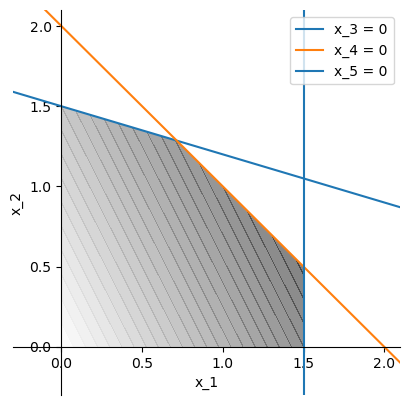

In [11]:
small_ex = LP(A_i_j = np.array([ [6,20],[1, 1], [1, 0]]),
              d_i = [30,2,1.5],
              c_j = np.array([2,1]),
              decision_var_names_j = ['x_1', 'x_2'],
              slack_var_names_i = ['x_3', 'x_4','x_5'])
small_ex.plot2d([])